Гузь Владислав, лабораторна 3.

In [2]:
import numpy as np
import scipy.stats as sc

Завантажуємо дані.

In [3]:
f1 = open('movie-ratings.txt')
f2 = open('review-ratings.txt')
movieRatings = f1.readlines()
reviewRatings = f2.readlines()
f1.close()
f2.close()

In [4]:
l1 = len(movieRatings)
l2 = len(reviewRatings)
for i in range(l1):
  if i != l1-1:
    movieRatings[i] = movieRatings[i][:-1].split(',')
  else:
    movieRatings[i] = movieRatings[i].split(',')
for i in range(l2):
  if i != l2-1:
    reviewRatings[i] = reviewRatings[i][:-1].split(',')
  else:
    reviewRatings[i] = reviewRatings[i].split(',')

In [5]:
movieRatings = np.array(movieRatings)
movieRatings = movieRatings[:, :-1].astype(np.int)

In [6]:
reviewRatings = np.array(reviewRatings, dtype=np.int)

Підрахуємо кількість користувачів.

In [7]:
users = set(list(np.concatenate([movieRatings[:, :1].reshape(movieRatings.shape[0]), reviewRatings[:, :1].reshape(reviewRatings.shape[0])])))
uL = len(users)

Підрахуємо кількість фільмів.

In [8]:
movies= set(list(movieRatings[:, 1:2].reshape(movieRatings.shape[0])))
mL = len(movies)

Створимо матрицю рейтингів.

За рейтинг беремо наступне: оцінка фільма деким користувачем, та якщо деякий користувач оцінив і фільм і звіт про фільм, беремо середнє арифметичне. Якщо тільки звіт, то беремо його рейтинг.

In [10]:
M = np.zeros(shape=(uL, mL), dtype=np.float16)

In [11]:
for el in movieRatings:
  userId = el[0] - 1
  movieId = el[1] - 1
  M[userId][movieId] = el[4]

for el in reviewRatings:
  userId = el[0] - 1
  reviewId = el[1] - 1
  reviewRating = el[2]
  movieRating = movieRatings[reviewId]
  movieId = movieRating[1] - 1
  if M[userId][movieId] == 0:
    M[userId][movieId] = reviewRating
  else:
    M[userId][movieId] = (M[userId][movieId] + reviewRating) / 2

In [42]:
Mcutted = M[:M.shape[0]//4, :M.shape[1]//3]
Mcutted.shape

(7611, 5373)

Реалізуємо алгоритм ймовірнісної матричної факторизації.

In [13]:
class ProbabilityMatrixFactorization():

  def  __init__(self, M, alpha, d, sigmaSquare):
    self.M = M
    self.alpha = alpha
    self.d = d
    self.sigmaSquare = sigmaSquare
    self.N1, self.N2 = M.shape[0], M.shape[1]
    self.V, self.U = sc.norm.rvs(scale=1/alpha, size=(d, self.N2)), None

  def score(self):
    temp = self.U @ self.V
    prod = (self.M[self.M > 0] - temp[self.M > 0])
    return -0.5 * ((1 / self.sigmaSquare) * np.sum(prod @ prod.T) + self.alpha * np.sum(self.U @ self.U.T) + self.alpha * np.sum(self.V @ self.V.T))

  def epoch_fit(self):
    temp = self.V[:, self.M[0, :] > 0]
    self.U = np.array([((np.linalg.inv(self.alpha * self.sigmaSquare * np.identity(self.d) + temp @ temp.T)) @ (np.sum(self.M[:1, self.M[0, :] > 0] * temp, axis=1).reshape(self.d, 1))).reshape(1, self.d)[0]])
    for i in range(1, self.N1):
      temp = self.V[:, self.M[i, :] > 0]
      self.U = np.concatenate((self.U, [((np.linalg.inv(self.alpha * self.sigmaSquare * np.identity(self.d) + temp @ temp.T)) @ (np.sum(self.M[i:i+1, self.M[i, :] > 0] * temp, axis=1).reshape(self.d, 1))).reshape(1, self.d)[0]]), axis=0)

    for j in range(self.N2):
      temp = self.U[self.M[:, j] > 0, :].T
      self.V[:, j] = ((np.linalg.inv(self.alpha * self.sigmaSquare * np.identity(self.d) + temp @ temp.T)) @ (np.sum(self.M[self.M[:, j] > 0, j:j+1].T[0] * temp, axis=1))).reshape(1, self.d)[0]

  def fit(self, epochs=10):
    scores = []
    for _ in range(epochs):
      self.epoch_fit()
      scores.append(self.score())
    return scores

Навчимо 5 моделей: 4 моделі з параметрами lambda = 1 та s^2 = 1, і d = 10, 20, 30, 40 і п'ята модель з параметрами lambda = 3, s^2 = 5, d = 40.

In [37]:
PMF1 = ProbabilityMatrixFactorization(Mcutted, alpha=1, d=10, sigmaSquare=1)
PMF2 = ProbabilityMatrixFactorization(Mcutted, alpha=1, d=20, sigmaSquare=1)
PMF3 = ProbabilityMatrixFactorization(Mcutted, alpha=1, d=30, sigmaSquare=1)
PMF4 = ProbabilityMatrixFactorization(Mcutted, alpha=1, d=40, sigmaSquare=1)

PMF5 = ProbabilityMatrixFactorization(Mcutted, alpha=3, d=40, sigmaSquare=5)

In [38]:
import time

t = time.time()
scores1 = PMF1.fit()
t1 = time.time() - t

t = time.time()
scores2 = PMF2.fit()
t2 = time.time() - t

t = time.time()
scores3 = PMF3.fit()
t3 = time.time() - t

t = time.time()
scores4 = PMF4.fit()
t4 = time.time() - t

t = time.time()
scores5 = PMF5.fit()
t5 = time.time() - t


Виведемо для кожної моделі MAP для кожної з 10 епох навчання.

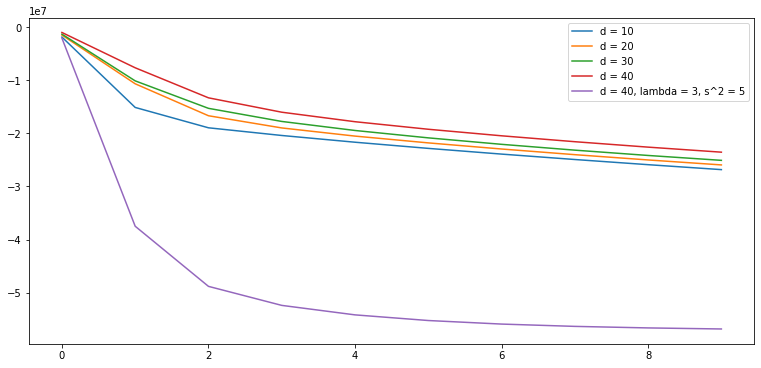

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(13, 6))
plt.plot(scores1, label='d = 10')
plt.plot(scores2, label='d = 20')
plt.plot(scores3, label='d = 30')
plt.plot(scores4, label='d = 40')
plt.plot(scores5, label='d = 40, lambda = 3, s^2 = 5')
plt.legend()
plt.show()

Виведемо час навчання.

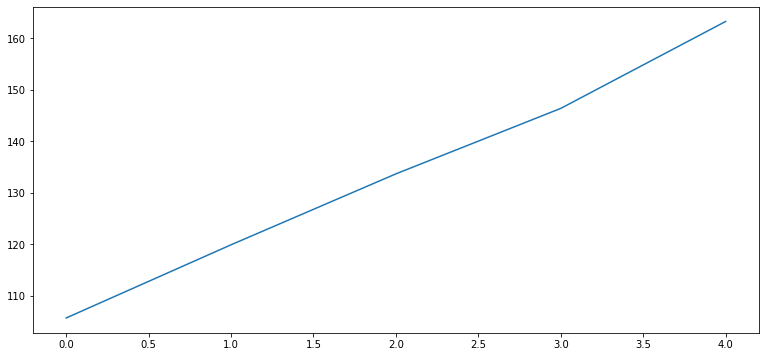

In [41]:
plt.figure(figsize=(13, 6))
plt.plot([t1, t2, t3, t4, t5])
plt.show()

Висновок.

Спочатку було створено рейтингову матрицю на основі оцінок фільмів та звітів до них.

Було натреновано 5 моделей: 4 моделі з параметрами lambda = 1 та s^2 = 1, і d = 10, 20, 30, 40 і п'ята модель з параметрами lambda = 3, s^2 = 5, d = 40.

Датасет вийшов дуже великим, тому, через обмеженність ОЗУ та величезного часу роботи, матрицю було урізано.

В результатах бачимо наступне: на перший погляд, 10 епох вистачило щоб отримати збіжність, але з іншого боку, ми оцінювали MAP, а це означає, що графіки повинні бути зростаючими. В данному випадку - вони спадають (так повинно було б бути, наприклад, для оцінки RMSE). Це означає, що моделі не навчилися. Можливо, треба по-іншому складати матрицю рейтингів.

Крім того, час для роботи зростає із зростанням параметру d, отже треба підбирати оптимальний d, такий що і працює не цілу вічність, і дає гарні результати.